## Goodreads Book Recommender

#### **Introduction**

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### **Contents**

**Part 0: Preprocessing**
- 0.1 - Load and Prepare Data
- 0.1 - Write Functions to Process Recommendations

**Part 1: Collaborative Filtering Based on Reader Similarity with KNN**
- 1.1 - Find Similar Readers
- 1.2 - Generate Recommendations

**Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization**
- 2.1 - Factorize User-Rating Matrix with SVD
- 2.2 - Generate Recommendations by Predicting Ratings
- 2.3 - Matrix Factorization with Gradient Descen

## Part 0: Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds
from skimage import io
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import AutoMinorLocator

In [2]:
# Set global variable of "sparse" or "dense"
# "sparse" will have user-item matrix with all books, "dense" only those in df_books
SPARSITY = "dense" 

# Choose K for small med and large neighborhoods
SM, MD, LG = 150, 750, 2500

# For titles in my_books that don't perfectly match df_books and can't be auto-matched
titles_to_replace = {
    "Children of Time (Children of Time #1)":"Children of Time",
    "King Leopold's Ghost: A Story of Greed, Terror, and Heroism in Colonial Africa":"King Leopold's Ghost",
    "Why We Love Dogs, Eat Pigs, and Wear Cows: An Introduction to Carnism":"Why We Love Dogs, Eat Pigs, and Wear Cows: An Introduction to Carnism: The Belief System That Enables Us to Eat Some Animals and Not Others",
    "Astrophysics for People in a Hurry (Astrophysics for People in a Hurry Series)":"Astrophysics for People in a Hurry",
    "Man-Eaters Of Kumaon":"The Temple Tiger and More Man-Eaters of Kumaon",    
    "Dune (Dune, #1)":"Dune (Dune Chronicles #1)"
}

# For books in my_books where there's a better book id to assign it
ids_to_replace = {
    25772375:234225
}

### 0.1 - Load and Prepare Data

In [3]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [4]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [5]:
# Create df_reviews that is less sparse than original
if SPARSITY == "dense":
    in_df_books = book_index["book_id"].isin(df_books["book_id"])
    book_index = book_index[in_df_books].reset_index().drop("index", axis=1)
    df_reviews = df_reviews[:, in_df_books]
print(f"User-Item Matrix: {df_reviews.shape[0]:,} readers by {df_reviews.shape[1]:,} books")    

User-Item Matrix: 245,119 readers by 315,354 books


In [6]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")
my_books["Title"].replace(titles_to_replace, inplace=True)
my_books["Book Id"].replace(ids_to_replace, inplace=True)

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# First match on book_id
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="inner", on="book_id", suffixes=["_mb","_dfb"]
            ).rename(columns={"title_dfb":"title"}).drop("title_mb", axis=1)
print(f"Matching on book_id: {my_books_1.shape[0]}")

# Next match on title
my_books_2 = pd.merge(
    my_books[~my_books["book_id"].isin(my_books_1["book_id"])], # not matched on id
    df_books[["book_id", "title", "ratings_count", "avg_rating"]], 
    how="inner", on="title", suffixes=["_mb","_dfb"]
    ).sort_values(["title", "ratings_count"], ascending=False)\
     .drop_duplicates(subset=["title"])\
     .rename(columns={"book_id_dfb":"book_id"})
print(f"Matching on title: {my_books_2[~my_books_2['book_id'].isin(my_books_1['book_id'])].shape[0]}")

# Concat matching on book_id and matching on title
my_books_3 = pd.concat([my_books_1, my_books_2[["book_id", "rating", "title"]]])\
               .drop_duplicates(subset="title")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

# Reshape to sparse matrix dimensions
my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers
norm = Normalizer()
row_norms = np.sqrt(np.sum(df_reviews.power(2), axis=1)) # save row norms to un-normalzie later
df_reviews = norm.fit_transform(df_reviews) 

Target reader ratings: 176
Matching on book_id: 88
Matching on title: 24
Total matches: 112, 63.64% of total


In [7]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [8]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i] * float(row_norms[int(nt.user)])) 
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#(?:[2-9]|[1-9]\d+)"
    regex2 = r"Vol. (?:[0-9]|[1-9]\d+)"
    regex3 = r"Volume (?:[0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings, dists

In [9]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=100, n_recs=20, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))   

    others_ratings = others.groupby("book_id")["user_rating"].mean()\
                                                .reset_index()\
                                                .rename(columns={"user_rating":"similar_usr_avg"})

    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url", "book_id"])["uid"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g").sort_values(by="predicted_rating", 
                                                                                   ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )
        
        highest_rated_recs_genre = pd.merge(highest_rated_recs_genre, others_ratings, how="left", on="book_id")
        
        highest_rated_recs_genre["similar_usr_avg"] = highest_rated_recs_genre["similar_usr_avg"].round(2)
        
        cols = ["title", "avg_rating", "similar_usr_avg", "ratings_count", "year", "url"]
        highest_rated_recs_genre = highest_rated_recs_genre[cols]

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre.head(50))

        print(gs)
        display(highest_rated_recs_genre.head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [10]:
# Function to show most popular books among similar readers
def neighbors_most_popular(others, n=20, min_ratings=100, min_score=3.9, write_to_excel=False):
    
    others = pd.merge(others.groupby("book_id")["user_rating"].mean()\
                            .reset_index().rename(columns={"user_rating":"similar_usr_avg"}),
                      others,
                      on="book_id")
    others["similar_usr_avg"] = others["similar_usr_avg"].round(2)

    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "similar_usr_avg", "ratings_count", "year", "url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"%_similar_usr_read"})

    popular_recs["%_similar_usr_read"] = (popular_recs["%_similar_usr_read"] / 
                                            others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[
        ["title","avg_rating","similar_usr_avg", "ratings_count","year","%_similar_usr_read","url"]
    ]

In [11]:
# Function to show top rated among similar readers
def neighbors_top_rated(others, n=20, min_ratings=100, min_score=3.9, write_to_excel=False):

    others = pd.merge(others.groupby("book_id")["user_rating"].mean()\
                            .reset_index().rename(columns={"user_rating":"similar_usr_avg"}),
                      others,
                      on="book_id")
    others["similar_usr_avg"] = others["similar_usr_avg"].round(2)
    
    min_neighbor_ratings = np.max([others["uid"].nunique() / 200, 5])

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "similar_usr_avg", "ratings_count", "year", "url"])["uid"]\
        .count().reset_index().sort_values(by=["similar_usr_avg", "avg_rating", "uid"], ascending=False)\
        .query("uid >= @min_neighbor_ratings")\
        .nlargest(n, "similar_usr_avg").drop(columns="uid")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [12]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        color="mediumslateblue",
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        color="darkgray",
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.2,                    
                    # linestyle=(0, (1,1)),
                    linewidth=6.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

In [13]:
def display_top_books(preds, books, target_ratings):
    """
    Plots book cover images for top recommendations in top 5 genres

    Args:
        preds: prediction df yielded by get_recs()
        books: dataframe with all book info
        target_ratings: target user's book ratings

    Returns:
        None
    """
    # Get image_url for top preds
    plot_pred = pd.merge(
                    preds[["book_id", "predicted_rating"]], 
                    books[["book_id", "image_url", "main_genre"]], 
                    on="book_id"
                )

    # For each of the top 10 genres, get top 5 books
    top_genres = pd.DataFrame(target_ratings.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})[0:5]

    # Function to turn image url into image 
    def getImage(path, zoom=0.3):
        return OffsetImage(io.imread(path), zoom=zoom)

    # Plot
    fig, ax = plt.subplots(figsize=(13,7))
    for i in range(len(top_genres)): # For each of top genres
        genre = top_genres.index[i]
        g = float(genre[6:]) # Get genre number
        
        # Slice plot pred to genre and valid image url
        books_to_plot = plot_pred[ 
            (plot_pred["main_genre"] == g) & (plot_pred["image_url"].str.contains("images.gr-"))
            ].head(5)
        
        paths = [url for url in books_to_plot["image_url"]] # Get image urls
        x = [i * 10 + 10 for x in range(5)] # Set genre bucket
        y = [y for y in books_to_plot["predicted_rating"]] # get predicted rating as y

        # Plot
        ax.scatter(x,y,alpha=0) 

        # Plot image at xy
        for x0, y0, path in zip(x, y, paths):
            ab = AnnotationBbox(getImage(path), (x0 + np.random.uniform(-3.5,3.5), y0), frameon=True, pad=0.3)
            ax.add_artist(ab)
        
    plt.ylabel("Recommendation Strength", fontsize=12)
    plt.xlabel("\nGenre Grouping", fontsize=12)
    plt.title("Top Recommendations by Genre", y=1.02, fontsize=14)
    plt.xlim((5, 55))
    ax.spines[['right', 'top', 'left']].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    ax.yaxis.set_ticklabels([])
    ax.yaxis.grid(True, alpha=0.3) # Create y gridlines
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.grid(which="minor", visible=True, alpha=0.8) # Create x gridlines
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

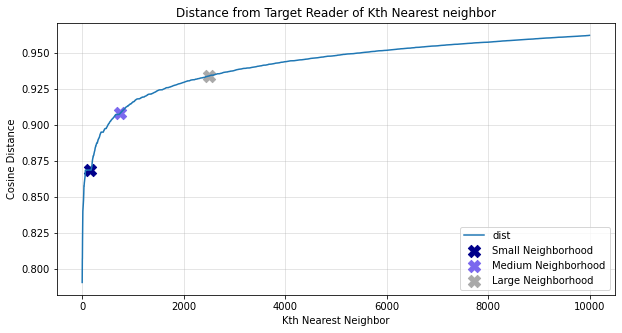

In [14]:
# Take a very large neighborhood to see how reader similarity decreases with K
n, t, dists = find_neighbors(10000, target, df_reviews, book_index, df_books)

# Plot distance by kth closest neighbor
fig, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(dists.T).rename(columns={0:"dist"})[1:10000].plot(ax=ax)
plt.title("Distance from Target Reader of Kth Nearest neighbor")
plt.xlabel("Kth Nearest Neighbor")
plt.ylabel("Cosine Distance")
ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
plt.scatter(SM, dists[0,SM], color="darkblue", marker="X", label="Small Neighborhood", s=150)
plt.scatter(MD, dists[0,MD], color="mediumslateblue", marker="X", label="Medium Neighborhood", s=150)
plt.scatter(LG, dists[0,LG], color="darkgray", marker="X", label="Large Neighborhood", s=150)
plt.legend()
plt.show()

In [15]:
# Perform KNN on user rating matrix
sm_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        SM, target, df_reviews, book_index, df_books)

# Find med number of similar users than before to get broader pool of potentially relevant books
med_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                    MD, target, df_reviews, book_index, df_books)

# Find larger number of similar users 
lg_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        LG, target, df_reviews, book_index, df_books)

print(f"Small neighborhood contains {sm_neighborhood_ratings['book_index'].nunique():,} books, " \
        f"{sm_neighborhood_ratings['uid'].nunique():,} readers")
print(f"Medium neighborhood contains {med_neighborhood_ratings['book_index'].nunique():,} books, " \
        f"{med_neighborhood_ratings['uid'].nunique():,} readers")
print(f"Large neighborhood contains {lg_neighborhood_ratings['book_index'].nunique():,} books, " \
        f"{lg_neighborhood_ratings['uid'].nunique():,} readers")

Small neighborhood contains 563 books, 59 readers
Medium neighborhood contains 4,488 books, 594 readers
Large neighborhood contains 15,881 books, 2,290 readers


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

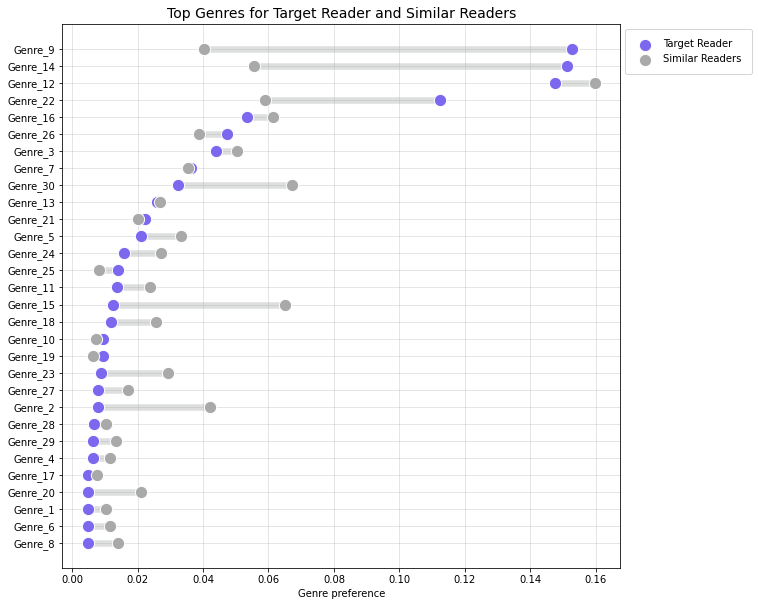

In [16]:
# Show top genres
plot_top_genres(sm_neighborhood_ratings, target_user_ratings)

In [17]:
# View most popular books among neighbors
neighbors_most_popular(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,similar_usr_avg,ratings_count,year,%_similar_usr_read,url
172,Ready Player One,4.31,4.29,376328.0,2011.0,11.9%,https://www.goodreads.com/book/show/9969571-re...
330,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.60,151473.0,2010.0,8.5%,https://www.goodreads.com/book/show/7235533-th...
288,The Martian,4.39,4.00,435440.0,2014.0,8.5%,https://www.goodreads.com/book/show/18007564-t...
155,"Old Man's War (Old Man's War, #1)",4.23,3.60,100702.0,2007.0,8.5%,https://www.goodreads.com/book/show/51964.Old_...
62,Dark Matter,4.10,3.20,75794.0,2016.0,8.5%,https://www.goodreads.com/book/show/27833670-d...
294,The Name of the Wind (The Kingkiller Chronicle...,4.55,4.50,416634.0,2007.0,6.8%,https://www.goodreads.com/book/show/186074.The...
277,"The Hunger Games (The Hunger Games, #1)",4.34,3.50,4899965.0,2008.0,6.8%,https://www.goodreads.com/book/show/2767052-th...
18,All the Light We Cannot See,4.31,4.50,498685.0,2014.0,6.8%,https://www.goodreads.com/book/show/18143977-a...
132,"Leviathan Wakes (The Expanse, #1)",4.20,4.00,72492.0,2011.0,6.8%,https://www.goodreads.com/book/show/8855321-le...
201,Snow Crash,4.02,3.25,179029.0,2000.0,6.8%,https://www.goodreads.com/book/show/830.Snow_C...


In [18]:
# View highest rated books among similar readers
neighbors_top_rated(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,similar_usr_avg,ratings_count,year,url
330,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.60,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
172,Ready Player One,4.31,4.29,376328.0,2011.0,https://www.goodreads.com/book/show/9969571-re...
288,The Martian,4.39,4.00,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
155,"Old Man's War (Old Man's War, #1)",4.23,3.60,100702.0,2007.0,https://www.goodreads.com/book/show/51964.Old_...
62,Dark Matter,4.10,3.20,75794.0,2016.0,https://www.goodreads.com/book/show/27833670-d...


In [19]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=sm_neighborhood_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.9, 
    n_recs=15,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Josephine B Trilogy,4.45,4.0,132.0,2006.0,https://www.goodreads.com/book/show/1308176.Th...
1,The Godfather,4.36,4.0,259150.0,2002.0,https://www.goodreads.com/book/show/22034.The_...
2,India After Gandhi: The History of the World's...,4.35,4.0,9652.0,2007.0,https://www.goodreads.com/book/show/356824.Ind...
3,A Thousand Splendid Suns,4.34,3.0,835172.0,2007.0,https://www.goodreads.com/book/show/128029.A_T...
4,On Writing: A Memoir of the Craft,4.31,4.0,135528.0,2002.0,https://www.goodreads.com/book/show/10569.On_W...
5,The Emperor of All Maladies: A Biography of Ca...,4.29,5.0,49534.0,2010.0,https://www.goodreads.com/book/show/7170627-th...
6,V for Vendetta,4.25,5.0,212464.0,2005.0,https://www.goodreads.com/book/show/5805.V_for...
7,Bury My Heart at Wounded Knee: An Indian Histo...,4.21,5.0,41180.0,2001.0,https://www.goodreads.com/book/show/76401.Bury...
8,The Red Tent,4.16,4.0,428809.0,2005.0,https://www.goodreads.com/book/show/4989.The_R...
9,North and South,4.13,2.0,98068.0,1994.0,https://www.goodreads.com/book/show/156538.Nor...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,On Tyranny: Twenty Lessons from the Twentieth ...,4.29,4.0,9145.0,2017.0,https://www.goodreads.com/book/show/33917107-o...
1,Our Revolution: A Future to Believe In,4.29,3.0,2430.0,2016.0,https://www.goodreads.com/book/show/31741420-o...
2,Elon Musk: Inventing the Future,4.24,3.0,63849.0,2015.0,https://www.goodreads.com/book/show/22543496-e...
3,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,5.0,11750.0,2015.0,https://www.goodreads.com/book/show/22535480-e...
4,Hun Sen’s Cambodia,4.20,3.0,105.0,2014.0,https://www.goodreads.com/book/show/21945075-h...
5,"Titan: The Life of John D. Rockefeller, Sr.",4.19,4.0,8970.0,2004.0,https://www.goodreads.com/book/show/16121.Titan
6,The Sleepwalkers: How Europe Went to War in 1914,4.18,4.0,3830.0,2012.0,https://www.goodreads.com/book/show/18669169-t...
7,"Blood Meridian, or the Evening Redness in the ...",4.18,5.0,72755.0,1992.0,https://www.goodreads.com/book/show/394535.Blo...
8,Daemon (Daemon #1),4.17,2.0,9355.0,2009.0,https://www.goodreads.com/book/show/6665847-da...
9,Amusing Ourselves to Death: Public Discourse i...,4.15,3.0,10133.0,1985.0,https://www.goodreads.com/book/show/74034.Amus...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,A Night Without Stars,4.41,5.00,1758.0,2016.0,https://www.goodreads.com/book/show/28530221-a...
1,The Martian,4.39,4.00,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
2,The Stand,4.34,2.00,449730.0,1978.0,https://www.goodreads.com/book/show/149267.The...
3,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,3.67,17174.0,2016.0,https://www.goodreads.com/book/show/32109569-w...
4,Judas Unchained,4.30,4.50,21306.0,2005.0,https://www.goodreads.com/book/show/45244.Juda...
5,"This Book Is Full of Spiders: Seriously, Dude,...",4.26,3.00,294.0,2013.0,https://www.goodreads.com/book/show/17286949-t...
6,"Pandora's Star (Commonwealth Saga, #1)",4.24,4.00,1312.0,2006.0,https://www.goodreads.com/book/show/6136470-pa...
7,"Old Man's War (Old Man's War, #1)",4.23,3.60,100702.0,2007.0,https://www.goodreads.com/book/show/51964.Old_...
8,Understand,4.22,4.00,869.0,2006.0,https://www.goodreads.com/book/show/7234685-un...
9,The Abyss Beyond Dreams,4.21,5.00,4944.0,2014.0,https://www.goodreads.com/book/show/20697413-t...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Behave: The Biology of Humans at Our Best and ...,4.40,5.00,830.0,2017.0,https://www.goodreads.com/book/show/31170723-b...
1,The Authoritarians,4.31,5.00,354.0,2006.0,https://www.goodreads.com/book/show/1971601.Th...
2,Chess Story,4.28,5.00,17661.0,2005.0,https://www.goodreads.com/book/show/59151.Ches...
3,Stories of Your Life and Others,4.27,4.67,17769.0,2010.0,https://www.goodreads.com/book/show/223380.Sto...
4,Writing Great Fiction: Storytelling Tips and T...,4.24,4.00,381.0,2014.0,https://www.goodreads.com/book/show/24235595-w...
5,The Hero With a Thousand Faces,4.24,4.00,18378.0,1972.0,https://www.goodreads.com/book/show/588138.The...
6,Dear Data,4.22,2.00,227.0,2016.0,https://www.goodreads.com/book/show/28465052-d...
7,Meditations,4.20,5.00,45727.0,2006.0,https://www.goodreads.com/book/show/30659.Medi...
8,"The Diamond Age: or, A Young Lady's Illustrate...",4.19,4.00,62866.0,2000.0,https://www.goodreads.com/book/show/827.The_Di...
9,Guns,4.17,4.00,3687.0,2013.0,https://www.goodreads.com/book/show/17284577-guns


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Pragmatic Programmer: From Journeyman to M...,4.31,5.0,9737.0,1999.0,https://www.goodreads.com/book/show/4099.The_P...
1,Your Deceptive Mind: A Scientific Guide to Cri...,4.30,4.0,1005.0,2012.0,https://www.goodreads.com/book/show/13562148-y...
2,The Dictator's Handbook: Why Bad Behavior is A...,4.27,3.0,2497.0,2011.0,https://www.goodreads.com/book/show/11612989-t...
3,Turn the Ship Around!: A True Story of Turning...,4.26,2.0,2684.0,2013.0,https://www.goodreads.com/book/show/16158601-t...
4,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,4.0,27705.0,2014.0,https://www.goodreads.com/book/show/18077903-c...
5,The Hard Thing About Hard Things: Building a B...,4.20,2.0,20745.0,2014.0,https://www.goodreads.com/book/show/18176747-t...
6,Deep Work: Rules for Focused Success in a Dist...,4.19,3.0,15605.0,2016.0,https://www.goodreads.com/book/show/25744928-d...
7,Your Best Brain: The Science of Brain Improvement,4.18,3.0,261.0,2014.0,https://www.goodreads.com/book/show/23626805-y...
8,Influence: The Psychology of Persuasion,4.18,5.0,47682.0,2006.0,https://www.goodreads.com/book/show/28815.Infl...
9,Work Rules!: Insights from Inside Google That ...,4.16,3.0,4902.0,2015.0,https://www.goodreads.com/book/show/22875447-w...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Gates of Fire: An Epic Novel of the Battle of ...,4.40,5.0,18299.0,2005.0,https://www.goodreads.com/book/show/1305.Gates...
1,"Dawn of Wonder (The Wakening, #1)",4.35,1.0,13351.0,2015.0,https://www.goodreads.com/book/show/25451852-d...
2,The Emperor's Soul,4.33,5.0,35260.0,2012.0,https://www.goodreads.com/book/show/13578175-t...
3,"The Lies of Locke Lamora (Gentleman Bastard, #1)",4.30,4.0,123373.0,2006.0,https://www.goodreads.com/book/show/127455.The...
4,"Outlander (Outlander, #1)",4.21,5.0,531055.0,2005.0,https://www.goodreads.com/book/show/10964.Outl...
5,Elantris,4.17,4.0,1420.0,2011.0,https://www.goodreads.com/book/show/10803709-e...
6,"Elantris (Elantris, #1)",4.17,4.5,100115.0,2006.0,https://www.goodreads.com/book/show/68427.Elan...
7,"Assassin's Apprentice (Farseer Trilogy, #1)",4.14,2.0,133239.0,1996.0,https://www.goodreads.com/book/show/45107.Assa...
8,Jane Eyre,4.10,3.0,1207986.0,1847.0,https://www.goodreads.com/book/show/10210.Jane...
9,"Red Queen (Red Queen, #1)",4.08,3.5,205243.0,2015.0,https://www.goodreads.com/book/show/22328546-r...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Man's Search for Meaning,4.33,3.5,179906.0,2006.0,https://www.goodreads.com/book/show/4069.Man_s...
1,Falling Upward: A Spirituality for the Two Hal...,4.24,4.0,4884.0,2011.0,https://www.goodreads.com/book/show/9963483-fa...
2,The Prophet,4.23,3.0,145579.0,2010.0,https://www.goodreads.com/book/show/2547.The_P...
3,Becoming Wise: An Inquiry into the Mystery and...,4.22,3.0,1683.0,2016.0,https://www.goodreads.com/book/show/25894085-b...
4,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,5.0,1659.0,2009.0,https://www.goodreads.com/book/show/5944774-de...
5,The Screwtape Letters,4.21,3.0,116487.0,2001.0,https://www.goodreads.com/book/show/11149.The_...
6,TED Talks: The Official TED Guide to Public Sp...,4.20,4.0,2368.0,2016.0,https://www.goodreads.com/book/show/25897871-t...
7,Have a Little Faith: a True Story,4.16,4.0,60867.0,2009.0,https://www.goodreads.com/book/show/1255781.Ha...
8,Imagining the Kingdom: How Worship Works,4.15,4.0,390.0,2013.0,https://www.goodreads.com/book/show/15863575-i...
9,The Essential Dalai Lama: His Important Teachings,4.12,3.0,315.0,2006.0,https://www.goodreads.com/book/show/237924.The...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Shoe Dog: A Memoir by the Creator of NIKE,4.44,4.0,27468.0,2016.0,https://www.goodreads.com/book/show/27220736-s...
1,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,5.0,95353.0,1997.0,https://www.goodreads.com/book/show/5544.Surel...
2,Masters of Doom: How Two Guys Created an Empir...,4.23,4.0,7357.0,2004.0,https://www.goodreads.com/book/show/222146.Mas...
3,No One Writes Back,4.19,1.0,154.0,2013.0,https://www.goodreads.com/book/show/17591572-n...
4,The Color Purple,4.17,1.0,380851.0,2004.0,https://www.goodreads.com/book/show/11486.The_...
5,Total Recall: My Unbelievably True Life Story,4.11,5.0,7295.0,2012.0,https://www.goodreads.com/book/show/14546626-t...
6,"Searching for Sunday: Loving, Leaving, and Fin...",4.09,4.0,5560.0,2015.0,https://www.goodreads.com/book/show/22574709-s...
7,The Rest Is Noise: Listening to the Twentieth ...,4.08,4.0,9607.0,2007.0,https://www.goodreads.com/book/show/392563.The...
8,Grace's Guide: The Art of Pretending to Be a G...,4.04,3.0,6917.0,2014.0,https://www.goodreads.com/book/show/22168240-g...
9,On the Move: A Life,4.03,4.0,9163.0,2015.0,https://www.goodreads.com/book/show/24972194-o...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,A Gentleman in Moscow,4.37,3.0,44419.0,2016.0,https://www.goodreads.com/book/show/29430012-a...
1,Jackalope Wives,4.35,5.0,460.0,2014.0,https://www.goodreads.com/book/show/20527580-j...
2,All the Light We Cannot See,4.31,4.5,498685.0,2014.0,https://www.goodreads.com/book/show/18143977-a...
3,"The Pillars of the Earth (Kingsbridge, #1)",4.29,5.0,471990.0,2002.0,https://www.goodreads.com/book/show/5043.The_P...
4,A Good Man is Hard to Find and Other Stories,4.24,5.0,26384.0,1992.0,https://www.goodreads.com/book/show/48464.A_Go...
5,The Waste Lands,4.24,4.0,121199.0,2003.0,https://www.goodreads.com/book/show/34084.The_...
6,The Drawing of the Three,4.23,4.0,143971.0,2003.0,https://www.goodreads.com/book/show/5094.The_D...
7,Neverwhere,4.18,2.0,275822.0,2003.0,https://www.goodreads.com/book/show/14497.Neve...
8,The Amazing Adventures of Kavalier & Clay,4.17,5.0,149976.0,2000.0,https://www.goodreads.com/book/show/3985.The_A...
9,Imajica,4.16,2.0,15828.0,1997.0,https://www.goodreads.com/book/show/567704.Ima...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Arcanum Unbounded: The Cosmere Collection,4.54,4.0,6493.0,2016.0,https://www.goodreads.com/book/show/28595941-a...
1,The Found and the Lost: The Collected Novellas...,4.43,2.0,182.0,2016.0,https://www.goodreads.com/book/show/29868611-t...
2,Beyond the Aquila Rift: The Best of Alastair R...,4.30,4.0,163.0,2016.0,https://www.goodreads.com/book/show/28931839-b...
3,The Circular Ruins,4.30,5.0,409.0,2010.0,https://www.goodreads.com/book/show/28110198-t...
4,2016 on Goodreads,4.25,4.0,1167.0,2016.0,https://www.goodreads.com/book/show/33232571-2...
5,"The Hedge Knight (The Tales of Dunk and Egg, #1)",4.23,3.0,14640.0,2005.0,https://www.goodreads.com/book/show/11970747-t...
6,Sixth of the Dusk,4.21,4.0,8122.0,2014.0,https://www.goodreads.com/book/show/23397921-s...
7,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,3.5,35184.0,1997.0,https://www.goodreads.com/book/show/386162.The...
8,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,3.0,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
9,Other People,4.19,4.0,373.0,2012.0,https://www.goodreads.com/book/show/16176131-o...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

#### 2.1 - Factorize User-Rating Matrix with SVD

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$\mathbf{R} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\top$$ where $\mathbf{U}$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

In [20]:
# Choose neighborhood size for SVD
svd_neighborhood_ratings = lg_neighborhood_ratings

In [21]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"Neighborhood contains {svd_neighbor_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]

Neighborhood contains 15,993 books


In [22]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=40)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [23]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

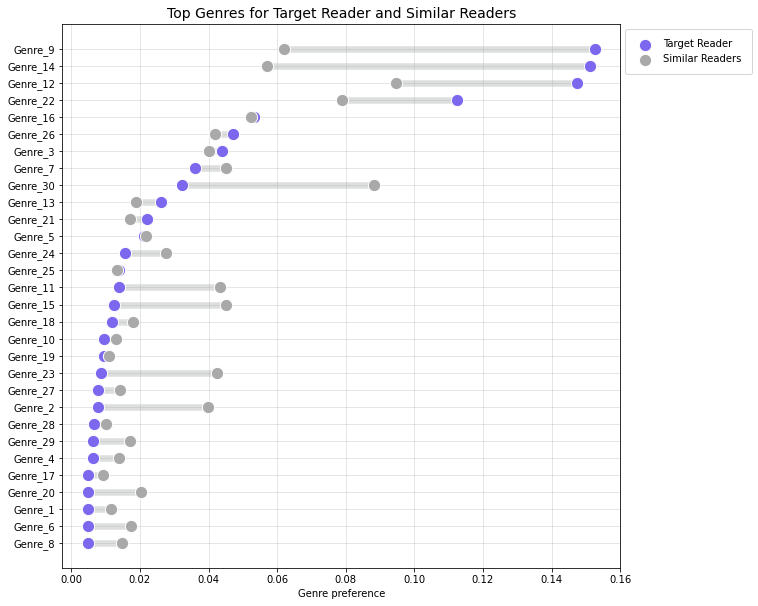

In [24]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [25]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:] * float(row_norms[target])

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [26]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.9").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
30,The Handmaid's Tale,4.07,1.899058,648783.0,1998.0,https://www.goodreads.com/book/show/38447.The_...
34,The Night Circus,4.03,1.157682,441272.0,2011.0,https://www.goodreads.com/book/show/9361589-th...
35,"Binti (Binti, #1)",4.02,1.100840,7945.0,2015.0,https://www.goodreads.com/book/show/25667918-b...
37,Dark Matter,4.10,1.078786,75794.0,2016.0,https://www.goodreads.com/book/show/27833670-d...
38,"Ancillary Justice (Imperial Radch, #1)",3.97,1.005175,40736.0,2013.0,https://www.goodreads.com/book/show/17333324-a...
39,"Old Man's War (Old Man's War, #1)",4.23,0.989788,100702.0,2007.0,https://www.goodreads.com/book/show/51964.Old_...
40,11/22/63,4.29,0.963571,265669.0,2011.0,https://www.goodreads.com/book/show/10644930-1...
41,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,0.927494,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
42,Good Omens: The Nice and Accurate Prophecies o...,4.25,0.904034,307430.0,2006.0,https://www.goodreads.com/book/show/12067.Good...
45,"Divergent (Divergent, #1)",4.23,0.885613,1962813.0,2012.0,https://www.goodreads.com/book/show/13335037-d...


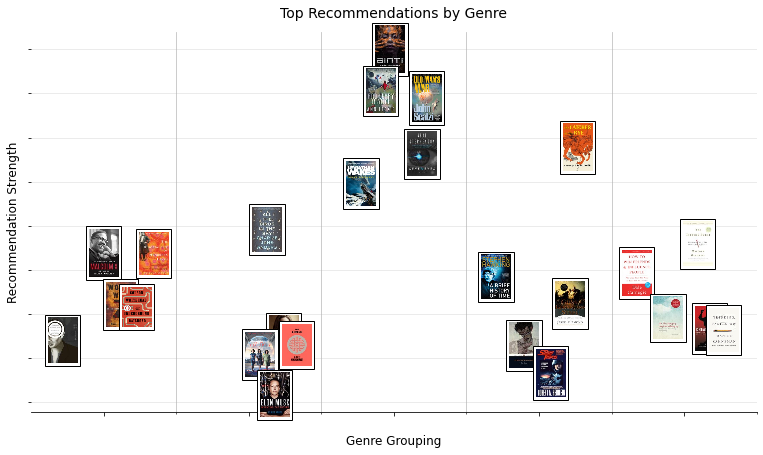

In [27]:
# Display top preds
display_top_books(top_preds, df_books, target_user_ratings)

In [28]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, n=50, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,similar_usr_avg,ratings_count,year,%_similar_usr_read,url
5926,The Martian,4.39,4.26,435440.0,2014.0,9.3%,https://www.goodreads.com/book/show/18007564-t...
3865,Ready Player One,4.31,4.09,376328.0,2011.0,8.1%,https://www.goodreads.com/book/show/9969571-re...
5648,"The Hunger Games (The Hunger Games, #1)",4.34,3.77,4899965.0,2008.0,5.9%,https://www.goodreads.com/book/show/2767052-th...
6025,The Name of the Wind (The Kingkiller Chronicle...,4.55,4.31,416634.0,2007.0,5.5%,https://www.goodreads.com/book/show/186074.The...
5340,The Fault in Our Stars,4.26,4.03,2429317.0,2012.0,5.1%,https://www.goodreads.com/book/show/11870085-t...
883,Brave New World,3.97,3.91,1043619.0,1998.0,4.2%,https://www.goodreads.com/book/show/5129.Brave...
422,"American Gods (American Gods, #1)",4.11,3.75,379668.0,2005.0,3.6%,https://www.goodreads.com/book/show/4407.Ameri...
5569,The Handmaid's Tale,4.07,3.95,648783.0,1998.0,3.6%,https://www.goodreads.com/book/show/38447.The_...
6353,The Road,3.95,3.80,513565.0,2006.0,3.4%,https://www.goodreads.com/book/show/6288.The_Road
474,"Ancillary Justice (Imperial Radch, #1)",3.97,3.74,40736.0,2013.0,3.4%,https://www.goodreads.com/book/show/17333324-a...


In [29]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, n=50, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,similar_usr_avg,ratings_count,year,url
703,Being Mortal: Medicine and What Matters in the...,4.41,4.94,60064.0,2014.0,https://www.goodreads.com/book/show/20696006-b...
5578,The Hate U Give,4.60,4.67,49663.0,2017.0,https://www.goodreads.com/book/show/32075671-t...
4235,Simon vs. the Homo Sapiens Agenda,4.26,4.64,61195.0,2015.0,https://www.goodreads.com/book/show/19547856-s...
7344,When Breath Becomes Air,4.32,4.63,131915.0,2016.0,https://www.goodreads.com/book/show/25899336-w...
6814,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.62,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
899,Bridge of Birds (The Chronicles of Master Li a...,4.30,4.62,8063.0,1985.0,https://www.goodreads.com/book/show/15177.Brid...
5675,The Importance of Being Earnest,4.17,4.60,216590.0,1895.0,https://www.goodreads.com/book/show/92303.The_...
2927,Lonesome Dove,4.47,4.59,113308.0,1999.0,https://www.goodreads.com/book/show/256008.Lon...
5271,The Emperor's Soul,4.33,4.59,35260.0,2012.0,https://www.goodreads.com/book/show/13578175-t...
1523,East of Eden,4.35,4.56,326016.0,2002.0,https://www.goodreads.com/book/show/4406.East_...


In [30]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Autobiography of Malcolm X,4.29,4.30,130860.0,1965.0,https://www.goodreads.com/book/show/92057.The_...
1,The Immortal Life of Henrietta Lacks,4.04,4.09,390601.0,2010.0,https://www.goodreads.com/book/show/6493208-th...
2,World War Z: An Oral History of the Zombie War,4.01,4.15,320129.0,2006.0,https://www.goodreads.com/book/show/8908.World...
3,The Underground Railroad,4.03,4.04,86839.0,2016.0,https://www.goodreads.com/book/show/30555488-t...
4,The Picture of Dorian Gray,4.06,4.08,607145.0,1998.0,https://www.goodreads.com/book/show/5297.The_P...
5,The Boys in the Boat: Nine Americans and Their...,4.33,4.28,118259.0,2013.0,https://www.goodreads.com/book/show/16158542-t...
6,Americanah,4.26,4.00,118938.0,2013.0,https://www.goodreads.com/book/show/15796700-a...
7,Les Misérables,4.14,4.35,519758.0,1987.0,https://www.goodreads.com/book/show/24280.Les_...
8,"Unbroken: A World War II Story of Survival, Re...",4.39,4.51,504961.0,2010.0,https://www.goodreads.com/book/show/8664353-un...
9,On Writing: A Memoir of the Craft,4.31,4.22,135528.0,2002.0,https://www.goodreads.com/book/show/10569.On_W...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Elon Musk: Inventing the Future,4.24,4.16,63849.0,2015.0,https://www.goodreads.com/book/show/22543496-e...
1,Fuzzy Nation,4.10,4.17,17539.0,2011.0,https://www.goodreads.com/book/show/9647532-fu...
2,"Daemon (Daemon, #1)",4.17,3.43,18162.0,NaN,https://www.goodreads.com/book/show/4699575-da...
3,The Caped Crusade: Batman and the Rise of Nerd...,4.15,4.50,1252.0,2016.0,https://www.goodreads.com/book/show/27276413-t...
4,Seabiscuit: An American Legend,4.20,3.75,113228.0,1999.0,https://www.goodreads.com/book/show/110737.Sea...
5,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,4.44,11750.0,2015.0,https://www.goodreads.com/book/show/22535480-e...
6,The Everything Store: Jeff Bezos and the Age o...,4.07,3.80,22546.0,2013.0,https://www.goodreads.com/book/show/17660462-t...
7,Poor Economics: A Radical Rethinking of the Wa...,4.22,4.00,6643.0,2011.0,https://www.goodreads.com/book/show/10245602-p...
8,The Battle For Justice In Palestine: The Case ...,4.25,5.00,182.0,2013.0,https://www.goodreads.com/book/show/17675081-t...
9,Lincoln on Leadership: Executive Strategies fo...,4.11,3.50,4166.0,1993.0,https://www.goodreads.com/book/show/1252.Linco...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Binti (Binti, #1)",4.02,3.89,7945.0,2015.0,https://www.goodreads.com/book/show/25667918-b...
1,"Old Man's War (Old Man's War, #1)",4.23,3.93,100702.0,2007.0,https://www.goodreads.com/book/show/51964.Old_...
2,"Leviathan Wakes (The Expanse, #1)",4.20,3.96,72492.0,2011.0,https://www.goodreads.com/book/show/8855321-le...
3,"I, Robot (Robot #0.1)",4.17,4.15,201196.0,2004.0,https://www.goodreads.com/book/show/41804.I_Robot
4,Childhood's End,4.09,4.06,89107.0,1953.0,https://www.goodreads.com/book/show/414999.Chi...
5,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,4.08,15139.0,2014.0,https://www.goodreads.com/book/show/22733729-t...
6,Do Androids Dream of Electric Sheep?,4.08,4.02,229370.0,1996.0,https://www.goodreads.com/book/show/7082.Do_An...
7,"The Forever War (The Forever War, #1)",4.15,3.90,89663.0,2003.0,https://www.goodreads.com/book/show/21611.The_...
8,The Moon is a Harsh Mistress,4.17,3.92,81655.0,2005.0,https://www.goodreads.com/book/show/16690.The_...
9,Anathem,4.18,4.16,45672.0,2008.0,https://www.goodreads.com/book/show/2845024-an...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,A Brief History of Time,4.13,4.22,173373.0,1998.0,https://www.goodreads.com/book/show/3869.A_Bri...
1,"The Diamond Age: or, A Young Lady's Illustrate...",4.19,3.77,62866.0,2000.0,https://www.goodreads.com/book/show/827.The_Di...
2,The Left Hand of Darkness,4.05,3.75,63749.0,2000.0,https://www.goodreads.com/book/show/18423.The_...
3,Pride and Prejudice,4.25,4.30,2078406.0,2000.0,https://www.goodreads.com/book/show/1885.Pride...
4,Stories of Your Life and Others,4.27,4.36,17769.0,2010.0,https://www.goodreads.com/book/show/223380.Sto...
5,The Sixth Extinction: An Unnatural History,4.10,4.08,22329.0,2014.0,https://www.goodreads.com/book/show/17910054-t...
6,Watchmen,4.35,4.31,406669.0,2005.0,https://www.goodreads.com/book/show/472331.Wat...
7,The Unbearable Lightness of Being,4.08,4.17,209734.0,2009.0,https://www.goodreads.com/book/show/9717.The_U...
8,"Legion (Legion, #1)",4.13,3.76,20774.0,2012.0,https://www.goodreads.com/book/show/13452375-l...
9,Steppenwolf,4.11,4.00,82556.0,1999.0,https://www.goodreads.com/book/show/16631.Step...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,How to Win Friends and Influence People,4.14,4.03,296690.0,1998.0,https://www.goodreads.com/book/show/4865.How_t...
1,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,4.32,27705.0,2014.0,https://www.goodreads.com/book/show/18077903-c...
2,"Thinking, Fast and Slow",4.09,4.30,144569.0,2011.0,https://www.goodreads.com/book/show/11468377-t...
3,The Power of Habit: Why We Do What We Do in Li...,4.03,4.15,160604.0,2012.0,https://www.goodreads.com/book/show/12609433-t...
4,Deep Work: Rules for Focused Success in a Dist...,4.19,4.20,15605.0,2016.0,https://www.goodreads.com/book/show/25744928-d...
5,Influence: The Psychology of Persuasion,4.18,4.31,47682.0,2006.0,https://www.goodreads.com/book/show/28815.Infl...
6,Being Mortal: Medicine and What Matters in the...,4.41,4.94,60064.0,2014.0,https://www.goodreads.com/book/show/20696006-b...
7,The End of Eternity,4.21,4.12,27229.0,1971.0,https://www.goodreads.com/book/show/509784.The...
8,"The Innovators: How a Group of Hackers, Geniu...",4.04,4.00,15567.0,2014.0,https://www.goodreads.com/book/show/21856367-t...
9,The Selfish Gene,4.12,4.24,98053.0,1976.0,https://www.goodreads.com/book/show/61535.The_...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Outlander (Outlander, #1)",4.21,3.19,531055.0,2005.0,https://www.goodreads.com/book/show/10964.Outl...
1,The Traitor Baru Cormorant (Baru Cormorant #1),4.04,4.13,5025.0,2015.0,https://www.goodreads.com/book/show/23444482-t...
2,The Goblin Emperor,4.05,3.66,12081.0,2014.0,https://www.goodreads.com/book/show/17910048-t...
3,The Poisonwood Bible,4.03,4.23,552392.0,2005.0,https://www.goodreads.com/book/show/7244.The_P...
4,"The Lies of Locke Lamora (Gentleman Bastard, #1)",4.30,4.45,123373.0,2006.0,https://www.goodreads.com/book/show/127455.The...
5,One Flew Over the Cuckoo's Nest,4.19,4.29,498475.0,1963.0,https://www.goodreads.com/book/show/332613.One...
6,East of Eden,4.35,4.56,326016.0,2002.0,https://www.goodreads.com/book/show/4406.East_...
7,The Queen of the Tearling (The Queen of the Te...,4.02,3.71,43751.0,2014.0,https://www.goodreads.com/book/show/18712886-t...
8,Tigana,4.12,4.00,31488.0,1999.0,https://www.goodreads.com/book/show/104089.Tigana
9,Shōgun,4.37,5.00,4818.0,1975.0,https://www.goodreads.com/book/show/38044.Sh_gun


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Quiet: The Power of Introverts in a World That...,4.04,4.12,208008.0,2012.0,https://www.goodreads.com/book/show/8520610-quiet
1,Man's Search for Meaning,4.33,4.25,179906.0,2006.0,https://www.goodreads.com/book/show/4069.Man_s...
2,The Subtle Art of Not Giving a F*ck: A Counter...,4.02,3.52,60032.0,2016.0,https://www.goodreads.com/book/show/28257707-t...
3,The Last Lecture,4.25,4.19,245804.0,2008.0,https://www.goodreads.com/book/show/2318271.Th...
4,Einstein: His Life and Universe,4.08,4.50,73712.0,2007.0,https://www.goodreads.com/book/show/10884.Eins...
5,The 7 Habits of Highly Effective People: Power...,4.05,3.47,330726.0,1989.0,https://www.goodreads.com/book/show/36072.The_...
6,The Power of Now: A Guide to Spiritual Enlight...,4.11,4.11,109355.0,1997.0,https://www.goodreads.com/book/show/6708.The_P...
7,The Righteous Mind: Why Good People are Divide...,4.16,4.44,13500.0,2012.0,https://www.goodreads.com/book/show/11324722-t...
8,Teachings on Love,4.34,3.50,817.0,2006.0,https://www.goodreads.com/book/show/263320.Tea...
9,The Almond Tree,4.11,4.50,2823.0,2012.0,https://www.goodreads.com/book/show/14929224-t...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,You're Never Weird on the Internet,4.14,4.19,29419.0,2015.0,https://www.goodreads.com/book/show/23705512-y...
1,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,4.05,95353.0,1997.0,https://www.goodreads.com/book/show/5544.Surel...
2,Shrill: Notes from a Loud Woman,4.22,4.33,17212.0,2016.0,https://www.goodreads.com/book/show/29340182-s...
3,Breakfast of Champions,4.08,3.59,180318.0,1999.0,https://www.goodreads.com/book/show/4980.Break...
4,Shoe Dog: A Memoir by the Creator of NIKE,4.44,4.33,27468.0,2016.0,https://www.goodreads.com/book/show/27220736-s...
5,That is All,4.03,4.00,1745.0,2011.0,https://www.goodreads.com/book/show/11065215-t...
6,Sam Walton: Made In America,4.08,4.50,9761.0,1992.0,https://www.goodreads.com/book/show/10631.Sam_...
7,"The Big Sleep (Philip Marlowe, #1)",4.03,4.00,85883.0,1988.0,https://www.goodreads.com/book/show/2052.The_B...
8,The Nix,4.11,4.14,25087.0,2016.0,https://www.goodreads.com/book/show/28251002-t...
9,Bluebeard,4.02,4.11,27417.0,1998.0,https://www.goodreads.com/book/show/9601.Blueb...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Night Circus,4.03,3.93,441272.0,2011.0,https://www.goodreads.com/book/show/9361589-th...
1,Dark Matter,4.10,3.84,75794.0,2016.0,https://www.goodreads.com/book/show/27833670-d...
2,Station Eleven,4.02,3.94,166920.0,2014.0,https://www.goodreads.com/book/show/20170404-s...
3,Cloud Atlas,4.01,4.12,155020.0,2004.0,https://www.goodreads.com/book/show/49628.Clou...
4,The Drawing of the Three,4.23,4.17,143971.0,2003.0,https://www.goodreads.com/book/show/5094.The_D...
5,The Waste Lands,4.24,4.12,121199.0,2003.0,https://www.goodreads.com/book/show/34084.The_...
6,The Shining,4.18,4.00,804918.0,1980.0,https://www.goodreads.com/book/show/11588.The_...
7,The Amazing Adventures of Kavalier & Clay,4.17,4.08,149976.0,2000.0,https://www.goodreads.com/book/show/3985.The_A...
8,One Hundred Years of Solitude,4.04,3.91,497852.0,2003.0,https://www.goodreads.com/book/show/320.One_Hu...
9,Hamlet,4.01,4.12,526122.0,2005.0,https://www.goodreads.com/book/show/1420.Hamlet


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,4.04,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
1,Bloodline,4.06,3.82,6476.0,2016.0,https://www.goodreads.com/book/show/27209239-b...
2,At the Mountains of Madness and Other Tales of...,4.25,4.40,19861.0,1931.0,https://www.goodreads.com/book/show/32769.At_t...
3,The Paper Menagerie and Other Stories,4.37,4.20,4081.0,2016.0,https://www.goodreads.com/book/show/24885533-t...
4,The Paper Menagerie,4.37,4.50,2476.0,2011.0,https://www.goodreads.com/book/show/13501210-t...
5,Saga: Book One,4.70,4.71,4201.0,2014.0,https://www.goodreads.com/book/show/22078240-saga
6,Arcanum Unbounded: The Cosmere Collection,4.54,4.27,6493.0,2016.0,https://www.goodreads.com/book/show/28595941-a...
7,The Call of Cthulhu and Other Weird Stories,4.25,3.50,26100.0,1999.0,https://www.goodreads.com/book/show/160149.The...
8,Nightfall and Other Stories,4.27,4.33,10420.0,1969.0,https://www.goodreads.com/book/show/70771.Nigh...
9,Welcome to the Monkey House,4.14,3.25,40756.0,2013.0,https://www.goodreads.com/book/show/4985.Welco...


_____



### 2.3 Matrix Factorization with Gradient Descent

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of the math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

In [31]:
# Choose neighborhood size for GD
gd_neighborhoodhood_ratings = med_neighborhood_ratings

In [32]:
# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"Neighborhood contains {gd_neighborhood_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

Neighborhood contains 4,600 books


In [33]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=15, steps=200, lr=0.0002, beta=0.01, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient                    

        # Calculate error every n steps                  
        if (((step + 1) / (steps / 5)) % 1 == 0) | (step == 0):                                  
            error = np.sum(pow(resid, 2)) + (beta/2) * np.linalg.norm(P,2) + np.linalg.norm(Q,2)
            
            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, Loss: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 1.5
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [34]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=45, 
                                    lr=0.02, 
                                    beta=1,
                                    decay=True, 
                                    steps=700, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, Loss: 1289276.48, lr: 0.02000
Step: 140, Loss: 216.75, lr: 0.01333
Step: 280, Loss: 431.18, lr: 0.00889
Step: 420, Loss: 498.09, lr: 0.00593
Step: 560, Loss: 520.97, lr: 0.00395
Step: 700, Loss: 530.39, lr: 0.00263


In [35]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_genres = list(pd.DataFrame(target_user_ratings.loc[:, "Genre_1":].sum(axis=0)\
                            .sort_values(ascending=False)).rename(columns={0:"target"})[0:5].index)
top_genres = [int(g[6:]) for g in top_genres]
top_preds_GD.query("avg_rating > 3.9 and ratings_count > 1000 and main_genre in @top_genres")\
    [["title","avg_rating","predicted_rating","ratings_count","year","url"]].head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
1,Pride and Prejudice,4.25,0.340913,2078406.0,2000.0,https://www.goodreads.com/book/show/1885.Pride...
8,"Rendezvous with Rama (Rama, #1)",4.06,0.335512,94581.0,2000.0,https://www.goodreads.com/book/show/112537.Ren...
18,Faust: First Part,3.93,0.332863,43801.0,1988.0,https://www.goodreads.com/book/show/14706.Faust
19,Chasers of the Light: Poems from the Typewrite...,4.27,0.332361,6690.0,2014.0,https://www.goodreads.com/book/show/20821097-c...
21,A Brief History of Time,4.13,0.331653,173373.0,1998.0,https://www.goodreads.com/book/show/3869.A_Bri...
22,The Wall,4.07,0.330539,12523.0,2005.0,https://www.goodreads.com/book/show/10031.The_...
24,An Unquiet Mind: A Memoir of Moods and Madness,4.03,0.329483,41959.0,1996.0,https://www.goodreads.com/book/show/361459.An_...
28,Every Patient Tells a Story: Medical Mysteries...,3.91,0.328950,4093.0,2009.0,https://www.goodreads.com/book/show/6691125-ev...
34,Ignore Everybody: and 39 Other Keys to Creativity,3.93,0.328115,10839.0,2009.0,https://www.goodreads.com/book/show/6162567-ig...
37,Child of All Nations,4.34,0.326002,2382.0,1975.0,https://www.goodreads.com/book/show/248069.Chi...


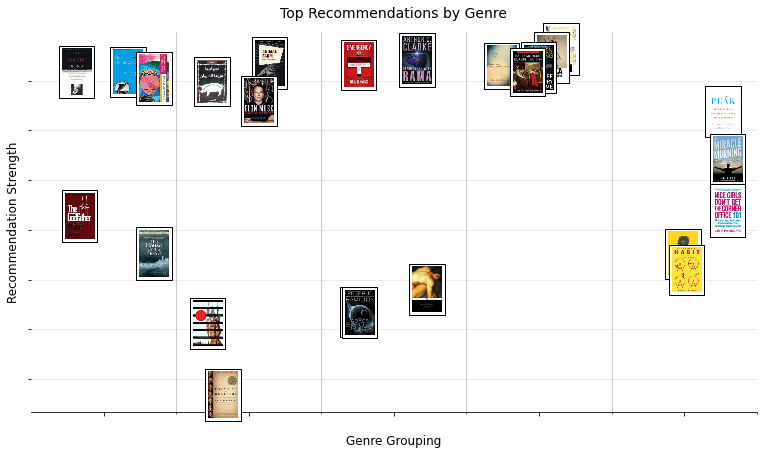

In [36]:
# Display top preds
display_top_books(top_preds_GD, df_books, target_user_ratings)

In [37]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(gd_neighborhoodhood_ratings, n=50, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,similar_usr_avg,ratings_count,year,%_similar_usr_read,url
1161,Ready Player One,4.31,4.02,376328.0,2011.0,9.1%,https://www.goodreads.com/book/show/9969571-re...
1813,The Martian,4.39,4.25,435440.0,2014.0,8.9%,https://www.goodreads.com/book/show/18007564-t...
1735,"The Hunger Games (The Hunger Games, #1)",4.34,3.54,4899965.0,2008.0,6.2%,https://www.goodreads.com/book/show/2767052-th...
1837,The Name of the Wind (The Kingkiller Chronicle...,4.55,4.44,416634.0,2007.0,6.1%,https://www.goodreads.com/book/show/186074.The...
879,"Leviathan Wakes (The Expanse, #1)",4.20,3.89,72492.0,2011.0,4.5%,https://www.goodreads.com/book/show/8855321-le...
2113,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.48,151473.0,2010.0,4.2%,https://www.goodreads.com/book/show/7235533-th...
1052,"Old Man's War (Old Man's War, #1)",4.23,4.00,100702.0,2007.0,4.2%,https://www.goodreads.com/book/show/51964.Old_...
144,"American Gods (American Gods, #1)",4.11,3.92,379668.0,2005.0,4.2%,https://www.goodreads.com/book/show/4407.Ameri...
164,"Ancillary Justice (Imperial Radch, #1)",3.97,3.92,40736.0,2013.0,4.2%,https://www.goodreads.com/book/show/17333324-a...
2219,Uprooted,4.12,3.91,65791.0,2015.0,3.9%,https://www.goodreads.com/book/show/22544764-u...


In [38]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(gd_neighborhoodhood_ratings, n=50, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,similar_usr_avg,ratings_count,year,url
1535,The Count of Monte Cristo,4.22,5.00,564778.0,2003.0,https://www.goodreads.com/book/show/7126.The_C...
1065,One Flew Over the Cuckoo's Nest,4.19,4.83,498475.0,1963.0,https://www.goodreads.com/book/show/332613.One...
2201,"Unbroken: A World War II Story of Survival, Re...",4.39,4.80,504961.0,2010.0,https://www.goodreads.com/book/show/8664353-un...
1542,"The Curse of Chalion (World of the Five Gods, #1)",4.16,4.80,21485.0,2003.0,https://www.goodreads.com/book/show/61886.The_...
1970,The Selfish Gene,4.12,4.80,98053.0,1976.0,https://www.goodreads.com/book/show/61535.The_...
499,East of Eden,4.35,4.67,326016.0,2002.0,https://www.goodreads.com/book/show/4406.East_...
133,All the Light We Cannot See,4.31,4.64,498685.0,2014.0,https://www.goodreads.com/book/show/18143977-a...
1764,The Kite Runner,4.26,4.62,1848782.0,2004.0,https://www.goodreads.com/book/show/77203.The_...
517,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,4.60,11750.0,2015.0,https://www.goodreads.com/book/show/22535480-e...
1140,Pride and Prejudice,4.25,4.59,2078406.0,2000.0,https://www.goodreads.com/book/show/1885.Pride...


In [39]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.9, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Wall,4.07,4.50,12523.0,2005.0,https://www.goodreads.com/book/show/10031.The_...
1,An Unquiet Mind: A Memoir of Moods and Madness,4.03,3.50,41959.0,1996.0,https://www.goodreads.com/book/show/361459.An_...
2,Child of All Nations,4.34,5.00,2382.0,1975.0,https://www.goodreads.com/book/show/248069.Chi...
3,Down and Out in Paris and London,4.10,4.33,35742.0,1972.0,https://www.goodreads.com/book/show/393199.Dow...
4,The Godfather,4.36,3.83,259150.0,2002.0,https://www.goodreads.com/book/show/22034.The_...
5,The House of the Dead,4.04,4.00,8548.0,2004.0,https://www.goodreads.com/book/show/17877.The_...
6,Fire: From A Journal of Love - The Unexpurgate...,4.12,3.00,506.0,1996.0,https://www.goodreads.com/book/show/18349.Fire
7,Infidel,4.20,5.00,59468.0,2007.0,https://www.goodreads.com/book/show/81227.Infidel
8,The Dream of a Ridiculous Man,4.07,4.00,4927.0,1877.0,https://www.goodreads.com/book/show/329866.The...
9,A Moveable Feast,4.04,4.40,71261.0,2012.0,https://www.goodreads.com/book/show/4631.A_Mov...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Elon Musk: Inventing the Future,4.24,4.20,63849.0,2015.0,https://www.goodreads.com/book/show/22543496-e...
1,How an Economy Grows and Why It Crashes,4.13,4.00,2224.0,2010.0,https://www.goodreads.com/book/show/7048818-ho...
2,Post-Capitalist Society,4.05,5.00,198.0,1994.0,https://www.goodreads.com/book/show/1083152.Po...
3,"Water Wars: Privatization, Pollution, and Profit",3.95,4.00,436.0,2002.0,https://www.goodreads.com/book/show/278193.Wat...
4,Founding Brothers: The Revolutionary Generation,3.92,3.67,32336.0,2000.0,https://www.goodreads.com/book/show/7493.Found...
5,Thank You for Being Late: An Optimist's Guide ...,3.96,3.00,3010.0,2016.0,https://www.goodreads.com/book/show/26114127-t...
6,The Little Book That Builds Wealth: The Knocko...,4.24,5.00,778.0,2008.0,https://www.goodreads.com/book/show/2389174.Th...
7,Hidden Figures: The American Dream and the Unt...,3.92,4.00,24753.0,2016.0,https://www.goodreads.com/book/show/25953369-h...
8,"The Quest: Energy, Security, and the Remaking ...",4.07,5.00,2378.0,2011.0,https://www.goodreads.com/book/show/11447065-t...
9,Animal Farm / 1984,4.26,4.50,120269.0,2003.0,https://www.goodreads.com/book/show/5472.Anima...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Rendezvous with Rama (Rama, #1)",4.06,3.50,94581.0,2000.0,https://www.goodreads.com/book/show/112537.Ren...
1,"Parable of the Sower (Earthseed, #1)",4.14,4.00,26932.0,2000.0,https://www.goodreads.com/book/show/52397.Para...
2,Anathem,4.18,4.18,45672.0,2008.0,https://www.goodreads.com/book/show/2845024-an...
3,The Abyss Beyond Dreams,4.21,4.00,4944.0,2014.0,https://www.goodreads.com/book/show/20697413-t...
4,"Ringworld (Ringworld, #1)",3.96,3.17,78483.0,2005.0,https://www.goodreads.com/book/show/61179.Ring...
5,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,3.87,15139.0,2014.0,https://www.goodreads.com/book/show/22733729-t...
6,Childhood's End,4.09,4.24,89107.0,1953.0,https://www.goodreads.com/book/show/414999.Chi...
7,"Leviathan Wakes (The Expanse, #1)",4.20,3.89,72492.0,2011.0,https://www.goodreads.com/book/show/8855321-le...
8,The Beach,3.91,5.00,53107.0,1998.0,https://www.goodreads.com/book/show/607639.The...
9,"The 5th Wave (The 5th Wave, #1)",4.10,3.00,270771.0,2013.0,https://www.goodreads.com/book/show/16101128-t...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Pride and Prejudice,4.25,4.59,2078406.0,2000.0,https://www.goodreads.com/book/show/1885.Pride...
1,Faust: First Part,3.93,3.50,43801.0,1988.0,https://www.goodreads.com/book/show/14706.Faust
2,Chasers of the Light: Poems from the Typewrite...,4.27,4.00,6690.0,2014.0,https://www.goodreads.com/book/show/20821097-c...
3,A Brief History of Time,4.13,4.12,173373.0,1998.0,https://www.goodreads.com/book/show/3869.A_Bri...
4,The True Believer: Thoughts on the Nature of M...,4.23,4.50,3244.0,2010.0,https://www.goodreads.com/book/show/15916.The_...
5,Inverting the Pyramid: The History of Football...,4.15,4.00,4682.0,2008.0,https://www.goodreads.com/book/show/3621358-in...
6,Brave New World,3.97,3.74,1043619.0,1998.0,https://www.goodreads.com/book/show/5129.Brave...
7,"The Vital Question: Energy, Evolution, and the...",4.14,5.00,843.0,2015.0,https://www.goodreads.com/book/show/23316494-t...
8,"Guns, Germs, and Steel: The Fates of Human Soc...",4.00,3.56,175410.0,2005.0,https://www.goodreads.com/book/show/1842.Guns_...
9,With Her Eyes,4.21,5.00,110.0,2012.0,https://www.goodreads.com/book/show/18160988-w...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Every Patient Tells a Story: Medical Mysteries...,3.91,4.00,4093.0,2009.0,https://www.goodreads.com/book/show/6691125-ev...
1,Ignore Everybody: and 39 Other Keys to Creativity,3.93,5.00,10839.0,2009.0,https://www.goodreads.com/book/show/6162567-ig...
2,Peak: Secrets from the New Science of Expertise,4.31,4.00,3084.0,2016.0,https://www.goodreads.com/book/show/26312997-peak
3,The Miracle Morning: The Not-So-Obvious Secret...,3.98,3.00,11294.0,2006.0,https://www.goodreads.com/book/show/17166225-t...
4,The Happiest Baby on the Block: The New Way to...,3.92,3.50,13295.0,2005.0,https://www.goodreads.com/book/show/132900.The...
5,The Power of Habit: Why We Do What We Do in Li...,4.03,4.00,160604.0,2012.0,https://www.goodreads.com/book/show/12609433-t...
6,Decisive: How to Make Better Choices in Life a...,3.97,5.00,8266.0,2013.0,https://www.goodreads.com/book/show/15798078-d...
7,Influence: The Psychology of Persuasion,4.18,5.00,47682.0,2006.0,https://www.goodreads.com/book/show/28815.Infl...
8,Seven Languages in Seven Weeks,3.98,4.00,1232.0,2010.0,https://www.goodreads.com/book/show/7912517-se...
9,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,4.44,27705.0,2014.0,https://www.goodreads.com/book/show/18077903-c...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,One Flew Over the Cuckoo's Nest,4.19,4.83,498475.0,1963.0,https://www.goodreads.com/book/show/332613.One...
1,"Seraphina (Seraphina, #1)",3.98,5.00,34791.0,2013.0,https://www.goodreads.com/book/show/19549841-s...
2,Shōgun,4.37,5.00,4818.0,1975.0,https://www.goodreads.com/book/show/38044.Sh_gun
3,Gates of Fire: An Epic Novel of the Battle of ...,4.40,5.00,18299.0,2005.0,https://www.goodreads.com/book/show/1305.Gates...
4,"Assassin's Apprentice (Farseer Trilogy, #1)",4.14,4.13,133239.0,1996.0,https://www.goodreads.com/book/show/45107.Assa...
5,"Thrawn (Star Wars: Thrawn, #1)",4.30,4.50,5220.0,2017.0,https://www.goodreads.com/book/show/31140332-t...
6,The 48 Laws of Power,4.18,1.33,39588.0,2000.0,https://www.goodreads.com/book/show/1303.The_4...
7,A Town Like Alice,4.12,3.00,36749.0,2000.0,https://www.goodreads.com/book/show/107301.A_T...
8,The Queen of the Tearling (The Queen of the Te...,4.02,3.00,43751.0,2014.0,https://www.goodreads.com/book/show/18712886-t...
9,The Poisonwood Bible,4.03,4.29,552392.0,2005.0,https://www.goodreads.com/book/show/7244.The_P...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Forty Rules of Love,4.17,4.00,36814.0,2010.0,https://www.goodreads.com/book/show/6642715-th...
1,ثم صار المخ عقلًا,4.08,4.00,493.0,NaN,https://www.goodreads.com/book/show/13559213
2,The World According to Mister Rogers: Importan...,4.32,3.00,1795.0,2003.0,https://www.goodreads.com/book/show/73123.The_...
3,My Journey : Transforming Dreams into Actions,4.35,5.00,1743.0,2013.0,https://www.goodreads.com/book/show/18371021-m...
4,The Last Lecture,4.25,5.00,245804.0,2008.0,https://www.goodreads.com/book/show/2318271.Th...
5,Philosophy for Life: And Other Dangerous Situa...,4.10,1.00,843.0,2012.0,https://www.goodreads.com/book/show/13629522-p...
6,We Should All Be Feminists,4.47,5.00,51354.0,2014.0,https://www.goodreads.com/book/show/22738563-w...
7,The Moral Landscape: How Science Can Determine...,3.91,5.00,14734.0,2010.0,https://www.goodreads.com/book/show/7785194-th...
8,The Sound of Paper,4.00,5.00,923.0,2004.0,https://www.goodreads.com/book/show/498501.The...
9,The Butterfly Effect: How Your Life Matters,4.11,4.00,1499.0,2010.0,https://www.goodreads.com/book/show/7672382-th...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Backstage Pass (Sinners on Tour, #1)",4.05,4.00,50470.0,2010.0,https://www.goodreads.com/book/show/8379374-ba...
1,An Ideal Husband,4.03,4.00,30337.0,2001.0,https://www.goodreads.com/book/show/5296.An_Id...
2,Con đường Hồi giáo,4.36,3.00,1088.0,2014.0,https://www.goodreads.com/book/show/21474711-c...
3,Groucho: The Life and Times of Julius Henry Marx,4.01,3.00,468.0,2001.0,https://www.goodreads.com/book/show/339611.Gro...
4,Save the Cat!: The Last Book on Screenwriting ...,4.05,4.00,7172.0,2005.0,https://www.goodreads.com/book/show/49464.Save...
5,A Streetcar Named Desire,3.97,4.00,202539.0,1952.0,https://www.goodreads.com/book/show/12220.A_St...
6,"The Art of Asking; or, How I Learned to Stop W...",3.97,5.00,20606.0,2014.0,https://www.goodreads.com/book/show/20980987-t...
7,Heaven And Hell: My Life In The Eagles (1974 2...,3.97,4.00,1286.0,2009.0,https://www.goodreads.com/book/show/2265789.He...
8,That is All,4.03,4.00,1745.0,2011.0,https://www.goodreads.com/book/show/11065215-t...
9,"One Summer: America, 1927",4.06,4.00,27950.0,2013.0,https://www.goodreads.com/book/show/17262366-o...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"The Maze Runner (Maze Runner, #1)",4.03,3.14,745820.0,2009.0,https://www.goodreads.com/book/show/6186357-th...
1,Laughter in the Dark,3.95,3.00,7389.0,2006.0,https://www.goodreads.com/book/show/8151.Laugh...
2,Brideshead Revisited: The Sacred and Profane M...,3.99,5.00,70315.0,1982.0,https://www.goodreads.com/book/show/30933.Brid...
3,One Hundred Years of Solitude,4.04,3.95,497852.0,2003.0,https://www.goodreads.com/book/show/320.One_Hu...
4,All the Light We Cannot See,4.31,4.64,498685.0,2014.0,https://www.goodreads.com/book/show/18143977-a...
5,The Drawing of the Three,4.23,4.08,143971.0,2003.0,https://www.goodreads.com/book/show/5094.The_D...
6,"The Devil in the White City: Murder, Magic, an...",3.99,3.78,316040.0,2003.0,https://www.goodreads.com/book/show/21996.The_...
7,Hamlet,4.01,4.40,526122.0,2005.0,https://www.goodreads.com/book/show/1420.Hamlet
8,The Night Circus,4.03,4.38,441272.0,2011.0,https://www.goodreads.com/book/show/9361589-th...
9,Cloud Atlas,4.01,4.33,155020.0,2004.0,https://www.goodreads.com/book/show/49628.Clou...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Garden of Forking Paths,4.40,5.00,1326.0,2010.0,https://www.goodreads.com/book/show/10438328-t...
1,Stephen Hawking's a Brief History of Time: A R...,4.10,5.00,315.0,1992.0,https://www.goodreads.com/book/show/17352.Step...
2,The Girl With the Dragon Tattoo: Wiki content ...,4.47,4.00,977.0,2011.0,https://www.goodreads.com/book/show/10618633-t...
3,Pedro Páramo,4.04,3.67,21159.0,1955.0,https://www.goodreads.com/book/show/38787.Pedr...
4,Come Close,3.93,4.00,705.0,2015.0,https://www.goodreads.com/book/show/24874364-c...
5,Bloodline,4.06,4.00,6476.0,2016.0,https://www.goodreads.com/book/show/27209239-b...
6,E não sobrou nenhum,4.23,4.00,139.0,NaN,https://www.goodreads.com/book/show/28093104-e...
7,A Short History of Reconstruction,3.97,3.00,949.0,1990.0,https://www.goodreads.com/book/show/132917.A_S...
8,The Call of Cthulhu and Other Weird Stories,4.25,4.00,26100.0,1999.0,https://www.goodreads.com/book/show/160149.The...
9,Superman: Whatever Happened to the Man of Tomo...,4.14,4.00,10607.0,1997.0,https://www.goodreads.com/book/show/161275.Sup...


_____

